In [1]:
!pip install av
import av
print(av.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 27.4 MB/s eta 0:00:00
12.0.0


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import UCF101
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os

# Funzione di collate personalizzata per filtrare le annotazioni non necessarie
def custom_collate(batch):
    saved_tensors = []
    for video, _, label in batch:
        saved_tensors.append(video)
    saved_tensors = torch.stack(saved_tensors)
    return saved_tensors

# Definizione delle trasformazioni per i dati
tfs = transforms.Compose([
    transforms.Lambda(lambda x: x.float() / 255.),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),  # Normalizzazione
    transforms.Lambda(lambda x: F.interpolate(x, size=(240, 320)))  # Ridimensionamento
])

# Percorso dei dati caricati
ucf_data_dir = "/content/drive/MyDrive/UCFDataset/UCF101/UCF-101"
ucf_label_dir = "/content/drive/MyDrive/UCFDataset/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist"
frames_per_clip = 10
step_between_clips = 25
batch_size = 8
frame_rate = 10

# Creazione del DataLoader per il set di addestramento
train_dataset = UCF101(ucf_data_dir, ucf_label_dir, frames_per_clip=frames_per_clip,
                      step_between_clips=step_between_clips, frame_rate = frame_rate, train=True, transform=tfs, num_workers = 16, output_format = "TCHW")
print("Len of dataset is ", len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate, num_workers = 0)

# Creazione del DataLoader per il set di test
test_dataset = UCF101(ucf_data_dir, ucf_label_dir, frames_per_clip=frames_per_clip,
                      step_between_clips=step_between_clips, frame_rate = frame_rate, train=False, transform=tfs, num_workers = 16, output_format = "TCHW")
print("Len of dataset is ", len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate, num_workers = 0)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/833 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 833/833 [09:42<00:00,  1.43it/s]


Len of dataset is  28467


100%|██████████| 833/833 [08:57<00:00,  1.55it/s]


Len of dataset is  11116


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TemporalShiftModule(nn.Module):
    def __init__(self, n_segment=8, shift_div=8):
        super(TemporalShiftModule, self).__init__()
        self.fold_div = shift_div
        self.n_segment = n_segment

    def forward(self, x):
        nt, c, h, w = x.size()
        n_batch = nt // self.n_segment
        x = x.view(n_batch, self.n_segment, c, h, w)

        fold = c // self.fold_div
        out = torch.zeros_like(x)

        out[:, :-1, :fold] = x[:, 1:, :fold]  # shift left
        out[:, 1:, fold: 2 * fold] = x[:, :-1, fold: 2 * fold]  # shift right
        out[:, :, 2 * fold:] = x[:, :, 2 * fold:]  # not shift

        return out.view(nt, c, h, w)

class VideoPredictionModel(nn.Module):
    def __init__(self, n_segment=8):
        super(VideoPredictionModel, self).__init__()
        self.n_segment = n_segment
        self.tsm = TemporalShiftModule(n_segment=n_segment, shift_div=8)

        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.encoder_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.encoder_conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Decoder
        self.decoder_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_conv3 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        # Apply TSM
        b, t, c, h, w = x.size()
        x = x.view(b * t, c, h, w)
        x = self.tsm(x)

        # Encoder
        x = F.relu(self.encoder_conv1(x))  # Shape: (B*T, 64, H, W)
        x = F.max_pool2d(x, 2)  # Shape: (B*T, 64, H/2, W/2)

        x = F.relu(self.encoder_conv2(x))  # Shape: (B*T, 128, H/2, W/2)
        x = F.max_pool2d(x, 2)  # Shape: (B*T, 128, H/4, W/4)

        x = F.relu(self.encoder_conv3(x))  # Shape: (B*T, 256, H/4, W/4)
        x = F.max_pool2d(x, 2)  # Shape: (B*T, 256, H/8, W/8)

        # Decoder
        x = F.relu(self.decoder_conv1(x))  # Shape: (B*T, 128, H/4, W/4)
        x = F.relu(self.decoder_conv2(x))  # Shape: (B*T, 64, H/2, W/2)
        x = self.decoder_conv3(x)  # Shape: (B*T, 3, H, W)

        # Reshape back to (B, T, C, H, W)
        x = x.view(b, t, c, h, w)

        # Optional: Apply a sigmoid to constrain output to [0, 1]
        x = torch.sigmoid(x)

        return x


In [20]:
class VideoPredictionModel(nn.Module):
    def __init__(self):
        super(VideoPredictionModel, self).__init__()
        # Encoder
        self.encoder_conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.encoder_conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.encoder_conv3 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))

        # Decoder
        self.decoder_conv1 = nn.ConvTranspose3d(256, 128, kernel_size=(3, 2, 2), stride=(1, 2, 2), padding=(1, 0, 0), output_padding=(0, 1, 1))
        self.decoder_conv2 = nn.ConvTranspose3d(128, 64, kernel_size=(3, 2, 2), stride=(1, 2, 2), padding=(1, 0, 0), output_padding=(0, 1, 1))
        self.decoder_conv3 = nn.ConvTranspose3d(64, 3, kernel_size=(3, 2, 2), stride=(1, 2, 2), padding=(1, 0, 0), output_padding=(0, 1, 1))

    def forward(self, x):
        # Encoder
        x = F.relu(self.encoder_conv1(x))  # Shape: (B, 64, D, H, W)
        x = F.max_pool3d(x, (1, 2, 2))  # Shape: (B, 64, D, H/2, W/2)

        x = F.relu(self.encoder_conv2(x))  # Shape: (B, 128, D, H/2, W/2)
        x = F.max_pool3d(x, (1, 2, 2))  # Shape: (B, 128, D, H/4, W/4)

        x = F.relu(self.encoder_conv3(x))  # Shape: (B, 256, D, H/4, W/4)
        x = F.max_pool3d(x, (1, 2, 2))  # Shape: (B, 256, D, H/8, W/8)


        # Decoder
        x = F.relu(self.decoder_conv1(x))  # Shape: (B, 256, D, H/8, W/8)
        x = F.relu(self.decoder_conv2(x))  # Shape: (B, 128, D, H/4, W/4)
        x = self.decoder_conv3(x)  # Shape: (B, 64, D, H/2, W/2)

        x = F.interpolate(x, size=(x.shape[2], 240, 320), mode='trilinear', align_corners=False) #zozzo enough

        return x


In [ ]:
print(len(train_loader))

1780


In [ ]:
# Libera la memoria cache di PyTorch
torch.cuda.empty_cache()

# Rimuovi la memoria non più utilizzata dalle memorie PyTorch CachingAllocator
torch.cuda.ipc_collect()


torch.Size([8, 3, 5, 240, 320])
torch.Size([8, 3, 5, 240, 320]) torch.Size([8, 3, 5, 240, 320])
Epoch [1/10], Loss: 0.8332
Epoch [2/10], Loss: 0.0011
Epoch [3/10], Loss: 0.0010
Epoch [4/10], Loss: 0.0008
Epoch [5/10], Loss: 0.0007
Epoch [6/10], Loss: 0.0007
Epoch [7/10], Loss: 0.0010
Epoch [8/10], Loss: 0.0007
Epoch [9/10], Loss: 0.0008
Epoch [10/10], Loss: 0.0007


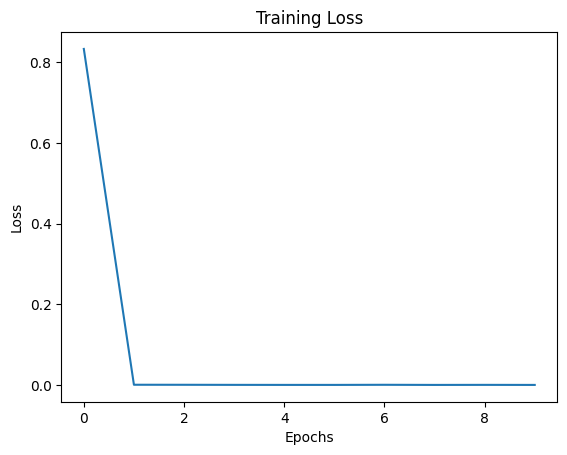

Finished Training


In [21]:
import matplotlib.pyplot as plt
import random
from torch.utils.data import Subset


# Definizione del modello e spostamento sulla GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VideoPredictionModel().to(device)

# Definizione della loss e dell'ottimizzatore
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Ciclo di addestramento
num_epochs = 10
num_frames_train = 5  # Numero di frame da utilizzare per l'addestramento
num_frames_pred = 5   # Numero di frame da predire
num_samples = 10
# Lista per memorizzare i valori della loss
loss_values = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    random_indices = random.sample(range(len(train_dataset)), num_samples)

    # Crea un Subset del dataset con gli indici casuali
    subset = Subset(train_dataset, random_indices)
    subset_loader = DataLoader(subset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate, num_workers=0)

    for batch_idx, batch in enumerate(subset_loader):
        frames = torch.permute(batch, (0,2,1,3,4))
        frames = frames.to(device)

        # Estrarre i frame di input e quelli target
        input_frames = frames[:, :, :num_frames_train, :, :]


        target_frames = frames[:, :, num_frames_train:num_frames_train+num_frames_pred, :, :]

        # Zero i gradienti
        optimizer.zero_grad()


        # Forward pass
        outputs = model(input_frames)

        if epoch == 0 and epoch == batch_idx:
            print(input_frames.shape)
            print(outputs.shape, target_frames.shape)

        # Calcolo della loss
        loss = criterion(outputs, target_frames)
        running_loss += loss.item()

        # Backward pass e ottimizzazione
        loss.backward()
        optimizer.step()

    # Calcolo della perdita media per epoca
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

# Tracciamento della perdita
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

print('Finished Training')


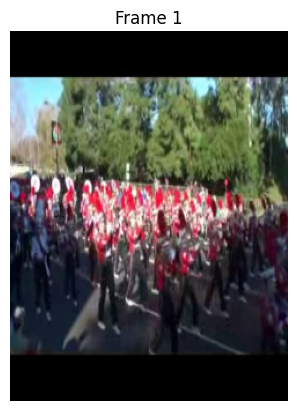

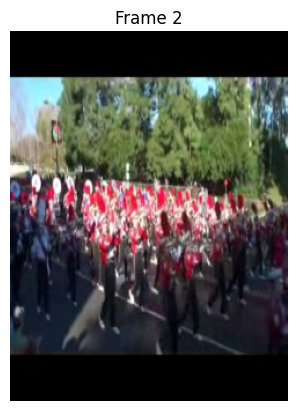

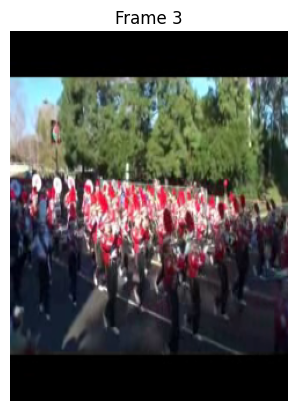

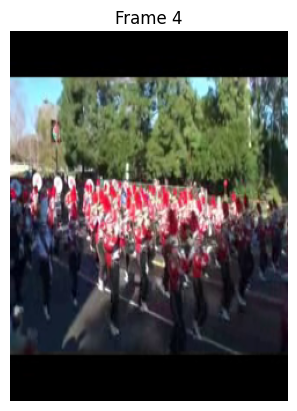

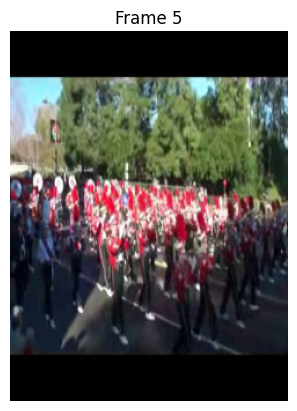

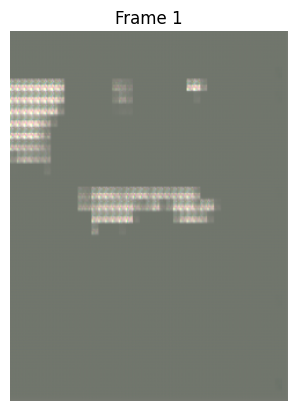

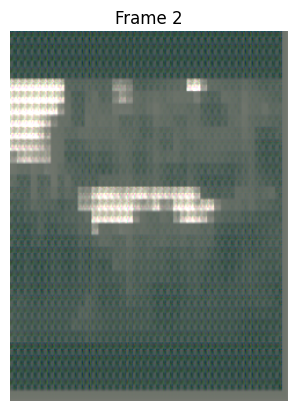

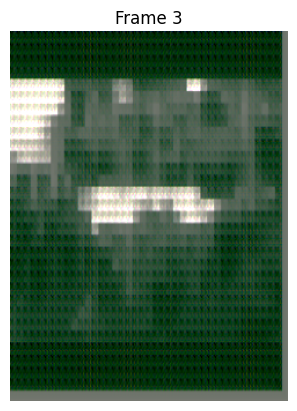

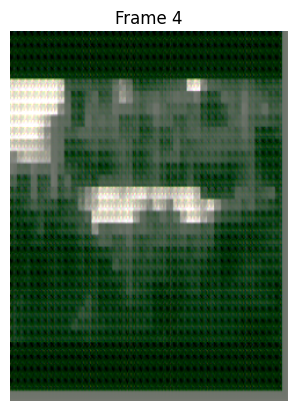

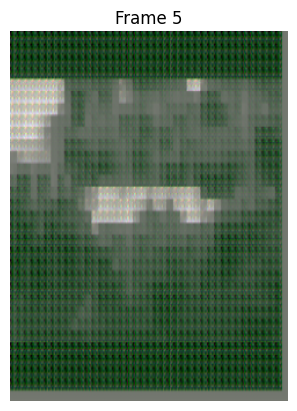

'\nfor batch_idx, batch in enumerate(train_loader):\n    for frames in batch:\n        denormalize_resize_and_display_frames(frames)\n\n        break\n    break\n'

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def denormalize_resize_and_display_frames(frames, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], target_size=(240, 320)):
    """
    Denormalizes, resizes, and displays a batch of frames.

    Args:
        frames (Tensor): Batch of frames (batch_size, num_channels, height, width).
        mean (list): List of mean values used for normalization.
        std (list): List of standard deviation values used for normalization.
        target_size (tuple): Target size for resizing the frames.
    """
    # Denormalizzazione
    mean = torch.FloatTensor(mean).to(device)
    std = torch.FloatTensor(std).to(device)

    frames = frames * std.view(1, 3, 1, 1) + mean.view(1, 3, 1, 1)

    # Trasposta i frames da (batch_size, num_channels, height, width) a (batch_size, height, width, num_channels)
    frames = frames.permute(0, 2, 3, 1)

    # Converti da tensore PyTorch a array NumPy
    frames = frames.cpu().detach().numpy()

    # Ridimensionamento dei frames
    resized_frames = []
    for frame in frames:
        resized_frame = cv2.resize(frame, target_size)
        resized_frames.append(resized_frame)
    resized_frames = np.array(resized_frames)

    # Riporta i valori nell'intervallo [0, 1]
    resized_frames = np.clip(resized_frames, 0, 1)

    # Stampa i frames
    for i, frame in enumerate(resized_frames):
        plt.figure()
        plt.imshow(frame)
        plt.title(f'Frame {i+1}')
        plt.axis('off')
        plt.show()

# Utilizzo della funzione
#denormalize_resize_and_display_frames(frames)
import matplotlib.pyplot as plt
import numpy as np
import cv2

for batch_idx, batch in enumerate(train_loader):
  if batch_idx == 2:

    frames = batch.to(device)
    # B=size of batch; C=number of channels; F=number of frames; H=height; W=width;
    # frames: BxFxCxHxW. Input of the network: BxCxFxHxW
    frames = torch.permute(frames,(0,2,1,3,4))

    # Estrarre i frame di input e quelli target
    input_frames = frames[:, :, :num_frames_train, :, :]


    target_frames = frames[:, :, num_frames_train:num_frames_train+num_frames_pred, :, :]
    outputs = model(input_frames)
    target_frames = torch.permute(target_frames,(0,2,1,3,4))
    outputs = torch.permute(outputs,(0,2,1,3,4))
    #denormalize_resize_and_display_frames(frames[0])
    denormalize_resize_and_display_frames(target_frames[0])
    denormalize_resize_and_display_frames(outputs[0])

    break
'''
for batch_idx, batch in enumerate(train_loader):
    for frames in batch:
        denormalize_resize_and_display_frames(frames)

        break
    break
'''

IDEAS


In [ ]:
import torch
import torch.nn as nn

class TextGuidedVideoPrediction(nn.Module):
    def __init__(self, text_embedding_dim, frame_embedding_dim, hidden_dim, num_frames):
        super(TextGuidedVideoPrediction, self).__init__()
        self.text_embedding = nn.Linear(text_embedding_dim, hidden_dim)
        self.frame_embedding = nn.Linear(frame_embedding_dim, hidden_dim)
        self.gru = nn.GRUCell(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, frame_embedding_dim)
        self.num_frames = num_frames

    def forward(self, text, frames):
        # text: (batch_size, text_embedding_dim)
        # frames: (batch_size, num_frames, frame_embedding_dim)

        # Embed text
        text_embedded = self.text_embedding(text)  # (batch_size, hidden_dim)

        # Initialize hidden state
        hidden_state = text_embedded

        # Initialize list to store predicted frames
        predicted_frames = []

        # Iterate over each frame
        for i in range(self.num_frames):
            # Get current frame
            frame = frames[:, i, :]  # (batch_size, frame_embedding_dim)

            # Combine text and frame features
            combined_features = hidden_state + self.frame_embedding(frame)

            # Update hidden state using GRU cell
            hidden_state = self.gru(combined_features, hidden_state)

            # Predict next frame
            predicted_frame = self.fc(hidden_state)

            # Append predicted frame to list
            predicted_frames.append(predicted_frame.unsqueeze(1))

        # Stack predicted frames along the temporal dimension
        predicted_frames = torch.cat(predicted_frames, dim=1)  # (batch_size, num_frames, frame_embedding_dim)

        return predicted_frames

# Esempio di utilizzo della rete
text_embedding_dim = 128
frame_embedding_dim = 64
hidden_dim = 256
num_frames = 10

# Creazione della rete
model = TextGuidedVideoPrediction(text_embedding_dim, frame_embedding_dim, hidden_dim, num_frames)

# Esempio di input
batch_size = 32
text_input = torch.randn(batch_size, text_embedding_dim)
frames_input = torch.randn(batch_size, num_frames, frame_embedding_dim)

# Esecuzione della predizione
predicted_frames = model(text_input, frames_input)

# Verifica delle dimensioni dell'output
print(predicted_frames.shape)  # Output: torch.Size([32, 10, 64])


In [ ]:
frame_rate_1 = 25
# Creazione del DataLoader per il set di addestramento
train_dataset_1 = UCF101(ucf_data_dir, ucf_label_dir, frames_per_clip=frames_per_clip,
                      step_between_clips=step_between_clips, frame_rate = frame_rate_1, train=True, transform=tfs, num_workers = 0, output_format = "TCHW")
print("Len of dataset is ", len(train_dataset_1))
train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=False, collate_fn=custom_collate, num_workers = 0)

frame_rate_2 = 10
# Creazione del DataLoader per il set di addestramento
train_dataset_2 = UCF101(ucf_data_dir, ucf_label_dir, frames_per_clip=frames_per_clip,
                      step_between_clips=step_between_clips, frame_rate = frame_rate_2, train=True, transform=tfs, num_workers = 0, output_format = "TCHW")
print("Len of dataset is ", len(train_dataset_2))
train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=False, collate_fn=custom_collate, num_workers = 0)

frame_rate_4 = 5
# Creazione del DataLoader per il set di addestramento
train_dataset_4 = UCF101(ucf_data_dir, ucf_label_dir, frames_per_clip=frames_per_clip,
                      step_between_clips=step_between_clips, frame_rate = frame_rate_4, train=True, transform=tfs, num_workers = 0, output_format = "TCHW")
print("Len of dataset is ", len(train_dataset_4))
train_loader_4 = DataLoader(train_dataset_4, batch_size=batch_size, shuffle=False, collate_fn=custom_collate, num_workers = 0)

In [ ]:
# Stampare un campione dai DataLoader di addestramento e test
print(len(train_loader), len(train_loader_1), len(train_loader_2), len(train_loader_4))

#check for first video
for sample in train_loader:
    sample = sample[0]
    for s2, s4 in zip(train_loader_2, train_loader_4):
        s2 = s2[0]
        s4 = s4[0]

        for i in range(15):
          for j in range(8):
            print(i, j, ((s2[j] - sample[i]) ** 2).mean())
          for j in range(4):
            print(i, j, ((s4[j] - sample[i]) ** 2).mean())
        break

    break

#check for all batches
for sample, sample1 in zip(train_loader, train_loader_1):
    for v, v1 in zip(sample,sample1):
        print(((v - v1) ** 2).mean())


#for idx, sample in enumerate(train_loader):
#    #videos = torch.stack(sample)
#    #file_name = f"train_batch_{idx}.pt"
#    #print(videos.shape)
#    for idx1, sample1 in enumerate(train_loader_1):
#        print(((sample - sample1)**2).mean())
#        break
#
#    break
    #with open("/content/drive/MyDrive/UCFDataset/TensorSavedData/" + file_name, "w"):
    #    torch.save(videos, os.path.join("/content/drive/MyDrive/UCFDataset/TensorSavedData", file_name))

#for idx, sample in enumerate(test_loader):
 #   videos = torch.stack(sample)
  #  file_name = f"test_batch_{idx}.pt"
   # print(videos.shape)
    #with open("/content/drive/MyDrive/UCFDataset/TensorSavedData/" + file_name, "w"):
     #   torch.save(videos, os.path.join("/content/drive/MyDrive/UCFDataset/TensorSavedData", file_name))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import UCF101
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
# Percorso dove sono stati salvati i tensori
saved_data_dir = "/content/drive/MyDrive/UCFDataset/TensorSavedData"

# Funzione per caricare i tensori salvati e riconvertirli in una lista
def load_videos(file_name):
    file_path = os.path.join(saved_data_dir, file_name)
    videos = torch.load(file_path)
    return list(videos)

TRAIN_BATCHES = 833
TEST_BATCHES = 833


# Recupero dei tensori salvati per il set di addestramento
train_videos = []
for idx in range(len(train_loader)):
    file_name = f"train_batch_{idx}"
    train_videos.extend(load_videos(file_name))

# Recupero dei tensori salvati per il set di test
test_videos = []
for idx in range(len(test_loader)):
    file_name = f"test_batch_{idx}"
    test_videos.extend(load_videos(file_name))

# Ora train_videos e test_videos contengono le liste di video recuperate dai tensori stackati


In [ ]:
# Funzione di collate personalizzata per filtrare le annotazioni non necessarie
def custom_collate(batch):
    saved_tensors = []  # Lista per salvare i tensori
    for video, _, label in batch:
        saved_tensors.append((video, label))  # Salvataggio del tensore e dell'etichetta
        #file_name = f"{os.path.basename(video)}.pt"  # Generazione del nome del file
        #torch.save(video, os.path.join("/content/drive/MyDrive/UCFDataset/TensorSavedData", file_name))  # Salvataggio del tensore
    return saved_tensors

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate, num_workers = 0)


In [ ]:
class VideoTransformer(nn.Module):
    def __init__(self, num_classes, num_frames=10):
        super(VideoTransformer, self).__init__()
        self.num_frames = num_frames

        # Definizione della parte convoluzionale della rete
        self.conv_layers = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        )

        # Definizione della parte transformer della rete
        self.transformer = nn.TransformerEncoderLayer(d_model=32, nhead=4)

        # Calcolo della dimensione dell'input al layer fully connected finale
        conv_output_size = self._get_conv_output_size((3, 60, 80))
        self.fc = nn.Linear(conv_output_size * num_frames, num_classes)

    def forward(self, x):
        # x ha forma (batch_size, num_frames, num_channels, height, width)
        batch_size = x.size(0)
        x = x.view(batch_size * self.num_frames, x.size(2), x.size(3), x.size(4))
        x = self.conv_layers(x)

        # Appiattimento dell'output per passare alla parte fully connected
        x = x.view(batch_size, self.num_frames, -1)
        x = x.permute(0, 2, 1)  # Permuta le dimensioni per adattarsi alla TransformerEncoderLayer
        x = self.transformer(x)

        # Appiattimento dell'output per passare al layer fully connected finale
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x

    def _get_conv_output_size(self, shape):
        dummy_input = torch.rand(1, *shape)
        dummy_output = self._forward_conv_layers(dummy_input)
        return dummy_output.view(1, -1).size(1)

    def _forward_conv_layers(self, x):
        for layer in self.conv_layers:
            x

# Definizione del modello
model = VideoTransformer(num_classes=len(train_dataset.classes))

# Definizione della funzione di perdita e dell'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Addestramento del modello
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for sample in train_loader:
        for inputs, labels in sample:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

# Valutazione del modello
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt

# Prendi una sequenza di frame da un campione casuale nel dataset
sample_video, label = ucf101_dataset[0]  # Cambia l'indice se vuoi esaminare un campione diverso

# Visualizza la sequenza di frame
fig, axes = plt.subplots(1, len(sample_video), figsize=(20, 5))

for i, frame in enumerate(sample_video):
    axes[i].imshow(frame.permute(1, 2, 0))
    axes[i].axis('off')

plt.show()
